In [19]:
from numpy import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *

dat = loadtxt('../data/gvmin/gvmin_SHMpp.txt')
v_min = dat[0,:]
gmin0 = dat[1:,:]
gmin0_gf = loadtxt('../data/gvmin/gvmin_SHMpp_GF.txt',skiprows=1)
gmin_sub = loadtxt('../data/gvmin/gvmin_Shards.txt',skiprows=1)
gmin_sub_gf = loadtxt('../data/gvmin/gvmin_Shards_GF.txt',skiprows=1)

ndays = shape(gmin0)[0]
days = linspace(0,365,ndays)





# Ionization energy range
n = 200
E_ee = logspace(log(0.01),log10(50.0),n)

# DAMA Config.
MT = 2.46
Avals = array([23,127])
Qvals = array([0.3,0.09])
def DAMAEnergyRes(Q,E_nr):
    alph = 0.448
    beta = 9.1e-3
    return alph*sqrt(Q*E_nr)+beta*Q*E_nr

Emask1 = (E_ee>1.0)*(E_ee<3.0)
Emask1 = (E_ee>1.0)*(E_ee<6.0)

# DM params
m_chi = 54.1
sigma_p = 1.0e-45

# diff rates
dR0_NaI = zeros(shape=(ndays,n,2))
dR_NaI = zeros(shape=(ndays,n,2))
dR0_gf_NaI = zeros(shape=(ndays,n,2))
dR_gf_NaI = zeros(shape=(ndays,n,2))

# total rates
R_NaI = zeros(shape=(ndays,2,2))
R0_NaI = zeros(shape=(ndays,2,2))
R_gf_NaI = zeros(shape=(ndays,2,2))
R0_gf_NaI = zeros(shape=(ndays,2,2))


for nuc in range(0,2):
    A = Avals[nuc]
    Q = Qvals[nuc]
    E_nr = E_ee/Q
    v_min_E = MinimumWIMPSpeed(E_nr,A,m_chi)
    sig_E = DAMAEnergyRes(Q,E_nr)
    for i in range(0,ndays):
        g0 = interp(v_min_E,v_min,gmin0[i,:])
        gs = interp(v_min_E,v_min,gmin_sub[i,:])
        g0_gf = interp(v_min_E,v_min,gmin0_gf[i,:])
        gs_gf = interp(v_min_E,v_min,gmin_sub_gf[i,:])
        dR_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,gs,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR_gf_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,gs_gf,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR0_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,g0,A,sigma_p,m_chi,rho_0=0.55),sig_E)
        dR0_gf_NaI[i,:,nuc] = SmearE(E_nr,diffRecoilRate_SI(E_nr,g0_gf,A,sigma_p,m_chi,rho_0=0.55),sig_E)        
        
        
        R_NaI[i,nuc,0] = MT*trapz(dR_NaI[i,Emask1,nuc],E_ee[Emask1])
        R_gf_NaI[i,nuc,0] = MT*trapz(dR_gf_NaI[i,Emask1,nuc],E_ee[Emask1])

        R0_NaI[i,nuc,0] = MT*trapz(dR0_NaI[i,Emask1,nuc],E_ee[Emask1])
        R0_gf_NaI[i,nuc,0] = MT*trapz(dR0_gf_NaI[i,Emask1,nuc],E_ee[Emask1])
        
        R_NaI[i,nuc,1] = MT*trapz(dR_NaI[i,Emask2,nuc],E_ee[Emask2])
        R_gf_NaI[i,nuc,1] = MT*trapz(dR_gf_NaI[i,Emask2,nuc],E_ee[Emask2])

        R0_NaI[i,nuc,1] = MT*trapz(dR0_NaI[i,Emask2,nuc],E_ee[Emask2])
        R0_gf_NaI[i,nuc,1] = MT*trapz(dR0_gf_NaI[i,Emask1,nuc],E_ee[Emask2])

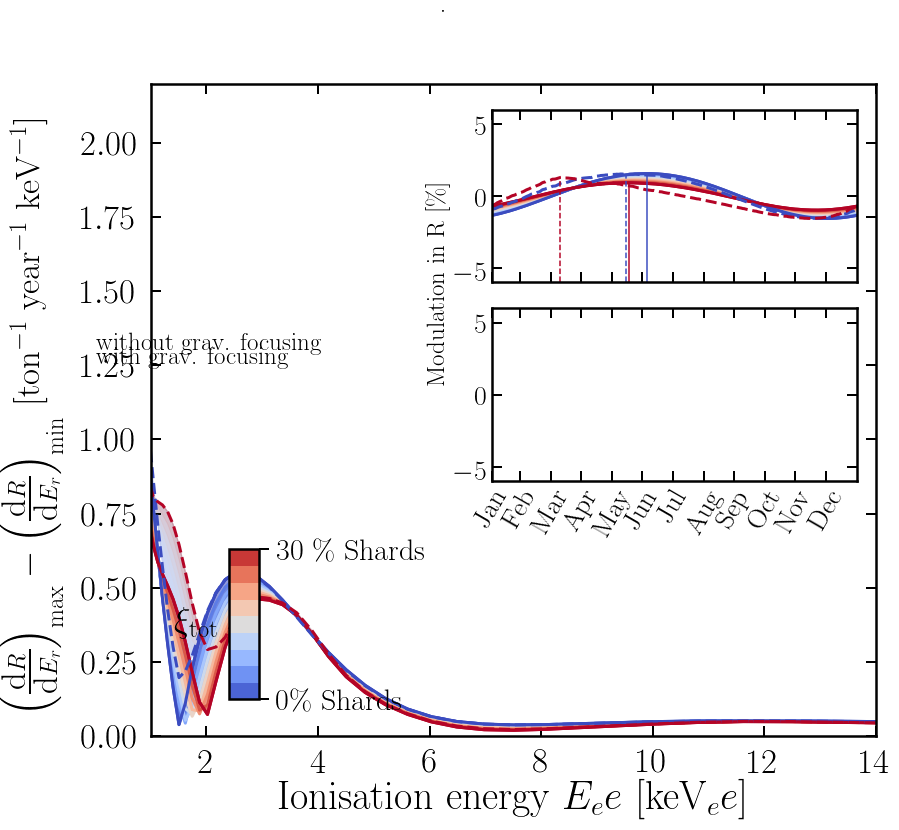

In [66]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

dR = sum(dR_NaI,2)
dR_gf = sum(dR_gf_NaI,2)
dR0 = sum(dR0_NaI,2)
dR0_gf = sum(dR0_gf_NaI,2)

R = sum(R_NaI,1)
R_gf = sum(R_gf_NaI,1)
R0 = sum(R0_NaI,1)
R0_gf = sum(R0_gf_NaI,1)

def ModulationAmplitude(dRv):
    t0 = 152
    t1 = mod(int(t0+ndays/2),364)
    ni = shape(dRv)[1]
    Rdiffv = zeros(shape=ni)
    for i in range(0,n):
        Rdiffv[i] = max(dRv[:,i])-min(dRv[:,i])
    return Rdiffv


# Figure
pltname = 'Shards_annualmod_gravfocus'
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(111)
left, bottom, width, height = [0.49, 0.65, 0.39, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
left, bottom, width, height = [0.49, 0.42, 0.39, 0.2]
ax3 = fig.add_axes([left, bottom, width, height])

n_xi = 10
xi_vals = linspace(0,0.35,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm

# Main plot
plt.sca(ax1)
y2 = ModulationAmplitude(xi_vals[-1]*dR+(1-xi_vals[-1])*dR0)
y2_gf = ModulationAmplitude(xi_vals[-1]*dR_gf+(1-xi_vals[-1])*dR0_gf)
for i in range(0,n_xi):
    y = ModulationAmplitude(xi_vals[i]*dR+(1-xi_vals[i])*dR0)
    plt.fill_between(E_ee,y,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(E_ee,y,'-',color=col[i,:],linewidth=3)
    
plt.plot(E_ee,ModulationAmplitude(dR0),linewidth=3,color=col[0,:])
plt.plot(E_ee,y2,linewidth=3,color=col[-1,:])


for i in range(0,n_xi):
    y = ModulationAmplitude(xi_vals[i]*dR_gf+(1-xi_vals[i])*dR0_gf)
    plt.fill_between(E_ee,y,y2=y2_gf,color=col[i,:],alpha=0.1)
plt.plot(E_ee,ModulationAmplitude(dR0_gf),'--',linewidth=3,color=col[0,:])
plt.plot(E_ee,y2_gf,'--',linewidth=3,color=col[-1,:])

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"Ionisation energy $E_ee$ [keV$_ee$]",fontsize=40);
plt.ylabel(r"$\left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm max} - \left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm min}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
ax1.set_xlim(left=1.0,right=14.0)
ax1.set_ylim(bottom=0.0)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=12)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
#ax1.set_xscale('log')

# second "legend"
ax1.plot([0.012,0.021],[1.32,1.32], 'k-',linewidth=3.5)
ax1.plot([0.012,0.021],[1.27,1.27], 'k--',linewidth=3.5)
ax1.text(0.023,1.35-0.045,'without grav. focusing',fontsize=25)
ax1.text(0.023,1.3-0.045,'with grav. focusing',fontsize=25)





# Inset plot
plt.sca(ax2)
ymax = 6

R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
R0mid_gf = (max(R0_gf)+min(R0_gf))/2.0
Rmid_gf = (max(R_gf)+min(R_gf))/2.0
y2 = 100*xi_vals[-1]*(R-Rmid)/Rmid+100*(1.0-xi_vals[-1])*(R0-R0mid)/R0mid
y2_gf = 100*xi_vals[-1]*(R_gf-Rmid_gf)/Rmid_gf+100*(1.0-xi_vals[-1])*(R0_gf-R0mid_gf)/R0mid_gf

for i in range(0,n_xi):
    Rt = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
    plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,Rt,'-',color=col[i,:],linewidth=3)
plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
plt.plot(days,y2,linewidth=3,color=col[-1,:])
plt.plot(days,100*(R0_gf-R0mid_gf)/R0mid_gf,'--',linewidth=3,color=col[0,:])
plt.plot(days,y2_gf,'--',linewidth=3,color=col[-1,:])

# vertical lines
diffR = 100*(R0-R0mid)/R0mid
plt.plot([days[argmax(diffR)],days[argmax(diffR)]],[-ymax,amax(diffR)],'-',color=col[0,:])
plt.plot([days[argmax(y2)],days[argmax(y2)]],[-ymax,amax(y2)],'-',color=col[-1,:])

diffR_gf = 100*(R0_gf-R0mid_gf)/R0mid_gf
plt.plot([days[argmax(diffR_gf)],days[argmax(diffR_gf)]],[-ymax,amax(diffR_gf)],'--',color=col[0,:])
plt.plot([days[argmax(y2_gf)],days[argmax(y2_gf)]],[-ymax,amax(y2_gf)],'--',color=col[-1,:])


#diffR_gf = 100*(R0_gf-R0mid_gf)/R0mid_gf
#plt.plot([days[argmax(diffR_gf)],days[argmax(diffR_gf)]],[-ymax,amax(diffR_gf)],'--',color=col[0,:])
#plt.plot([days[argmax(y2_gf)],days[argmax(y2_gf)]],[-ymax,amax(y2_gf)],'--',color=col[-1,:])


plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax2.set_xlim(left=0.0,right=365)
ax2.set_ylim(bottom=-ymax,top=ymax)
plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31)
plt.ylabel(r"Modulation in R [\%]" ,fontsize=25);
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=4,labelsize=28)
ax2.set_xticklabels([])

plt.sca(ax3)
plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=60)
ax3.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=4,labelsize=28)
ax3.set_xlim(left=0.0,right=365)
ax3.set_ylim(bottom=-ymax,top=ymax)

# Custom colorbar
cbar_max = r'30 \% Shards'
cbar_min = r'0\% Shards'
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax2, width="15%", height="30%", bbox_to_anchor=[30, -200, 200, 500]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[4]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.15,0.24,r'$\xi_{\rm tot}$',fontsize=35,color='k')


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

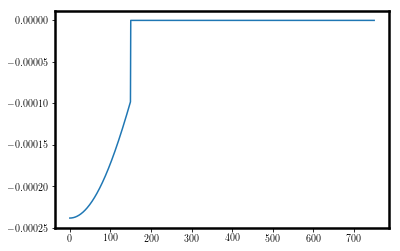

In [46]:


def ModulationAmplitude(dRv):
    t0 = 152
    t1 = mod(int(t0+ndays/2),364)
    ni = shape(dRv)[1]
    Rdiffv = zeros(shape=ni)
    for i in range(0,n):
        Rdiffv[i] = (dRv[t0,i]-dRv[t1,i])
    return Rdiffv

plt.plot(v_min,ModulationAmplitude(gmin0))
plt.show()

In [51]:
print gmin0[t0,700],gmin0[t1,700]

0.000188370718 0.000144706546


In [41]:
x = dR0[:,0]
t0 = argmax(x)

334